## Introduction
Recently, I learned about fixed base operators (FBOs).
FBOs are somewhat like the truck stops of the skies, providing fuel, parking, maintenance, and other amenities for private planes.
I was curious if I could use publicly available flight data to estimate the demand for FBOs in various places.

## Data Source
The Federal Aviation Adminstration (FAA) monitors air traffic operations in the United States.
Some of the data they collect is published in the operations network [OPSNET](https://aspm.faa.gov/opsnet/sys/main.asp).

From this page I selected tower operations because it includes local operations, or flights to and from the same airport that remain within a 20 mile radius of the tower.

![OPSNET Tower Operations Settings](OPSNET.png)

I used the following settings to generate the report:

**Output**

- Display: Standard Report
- Options:
  - Show IFR Itinerant
  - Show VFR Itinerant
  - Show IFR Overflight
  - Show VFR Overflight
  - Show Local
- Format
  - HTML
  - No Sub-Totals

**Dates**

- Months
  - From: Jan 2020
  - To: Jan 2024
  - All Days

**Facilities**

- Facility
- Enter Facility codes: (blank)

**Filters**

- No Filters

**Groupings**

- Date
- Facility
- State
- Region
- DDSO Service Area
- Class

I selected the HTML export because the excel file is a strange version of an excel file that is just HTML and is unable to be easily parsed with pandas.
When the web page with the data pops up, save the web page as a .html file.


- [what the columns mean](https://aspm.faa.gov/aspmhelp/index/OPSNET_Reports__Definitions_of_Variables.html)
- [API source for flights](https://aviationstack.com/documentation)
- [Airport arrivals](https://www.flightradar24.com/data/airports/srq/arrivals)

## Data Processing
Let's get started with the data!
First we import the packages we will use.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Next, we import the data file using the `read_html()` pandas function.
For this data, we skip the first row and define the header as the new rows `0` and `1`.
Importantly, the `read_html()` function returns a list of dataframes from the web page, so we must select it from the list (even if it's the only table present).

In [4]:

df_list = pd.read_html('OPSNET Report.htm', skiprows=1, header=[0,1])
# get the dataframe from the list
df = df_list[0]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24574 entries, 0 to 24573
Data columns (total 28 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   (Unnamed: 0_level_0, Date)                  24574 non-null  object 
 1   (Unnamed: 1_level_0, Facility)              24573 non-null  object 
 2   (IFR Itinerant, Air Carrier)                24574 non-null  int64  
 3   (IFR Itinerant, Air Taxi)                   24574 non-null  int64  
 4   (IFR Itinerant, General Aviation)           24574 non-null  int64  
 5   (IFR Itinerant, Military)                   24574 non-null  int64  
 6   (IFR Itinerant, Total)                      24574 non-null  int64  
 7   (IFR Overflight, Air Carrier)               24574 non-null  int64  
 8   (IFR Overflight, Air Taxi)                  24574 non-null  int64  
 9   (IFR Overflight, General Aviation)          24574 non-null  int64  
 10  (IFR Overf

We've got a bit of a problem with the column labels.
Since we gave the import function two columns, it created a multi-index for each column.
There are some use cases where this could be helpful, like if we needed to indicate a hierarchical relationship, but we will get rid of them for our case.

In [5]:
# list to hold new column names
new_names = []
# for every (ugly) column name
for col in df.columns:
    # list to hold pieces of multi-index col name
    col_name = []
    # for each piece
    for item in col:
        # Ignore Unnamed... cols and capture the rest
        if not item.startswith("Unnamed"):
            col_name.append(item)
    # new column name is joined with a space
    new_names.append(' '.join(col_name))

df.columns = new_names
df.tail()

,Date,Facility,IFR Itinerant Air Carrier,IFR Itinerant Air Taxi,IFR Itinerant General Aviation,IFR Itinerant Military,IFR Itinerant Total,IFR Overflight Air Carrier,IFR Overflight Air Taxi,IFR Overflight General Aviation,...,VFR Overflight Air Taxi,VFR Overflight General Aviation,VFR Overflight Military,VFR Overflight Total,Local Civil,Local Military,Local Total,Airport Operations,Tower Operations,
24569,11/2023,XNA,2126,240,432,144,2942,0,18,162,...,31,456,0,487,29,128,157,3229,3898,NaN
24570,11/2023,YIP,210,1026,989,2,2227,1,3,7,...,0,83,0,83,3669,1,3670,7149,7243,NaN
24571,11/2023,YKM,69,237,421,18,745,0,0,0,...,8,35,13,56,1260,24,1284,2789,2845,NaN
24572,11/2023,YNG,10,271,364,208,853,0,3,11,...,18,56,2,76,529,220,749,2121,2211,NaN
24573,Total:,NaN,53884379,15657379,17948496,2998060,90488314,771481,326278,758070,...,2277056,5949567,790423,9021613,54636474,3837777,58474251,195643567,206719649,NaN


Looks like we have a grand total row at the bottom. let's get rid of that.
Also, we need to process the date so pandas can recognize it.

In [6]:
df.drop(df.tail(1).index, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,24573,2021-12-02 06:55:39.372481792,2020-01-01 00:00:00,2020-12-01 00:00:00,2021-12-01 00:00:00,2022-12-01 00:00:00,2023-11-01 00:00:00,NaN
IFR Itinerant Air Carrier,24573.0,2192.828674,0.0,0.0,35.0,838.0,67427.0,6643.779052
IFR Itinerant Air Taxi,24573.0,637.178163,0.0,107.0,294.0,724.0,19451.0,1077.859121
IFR Itinerant General Aviation,24573.0,730.415334,0.0,264.0,505.0,918.0,7179.0,727.329212
IFR Itinerant Military,24573.0,122.006267,0.0,5.0,24.0,97.0,3004.0,274.108138
IFR Itinerant Total,24573.0,3682.428438,0.0,579.0,1246.0,3070.0,73352.0,7527.941508
IFR Overflight Air Carrier,24573.0,31.395475,0.0,0.0,0.0,2.0,13386.0,380.53375
IFR Overflight Air Taxi,24573.0,13.277907,0.0,0.0,1.0,5.0,2072.0,55.974537
IFR Overflight General Aviation,24573.0,30.849713,0.0,0.0,4.0,20.0,1783.0,94.489299
IFR Overflight Military,24573.0,8.083669,0.0,0.0,0.0,2.0,1018.0,40.671857


Now we need to look closely at the meanings of these columns to see what data is useful to us.
Fortunately, these [OPSNET terms](https://aspm.faa.gov/aspmhelp/index/OPSNET_Reports__Definitions_of_Variables.html) are clearly defined.
Airplane size is indicated by the following words:

- **Air Carrier**: > 60 seats or >18,000 lb. payload, carrying passengers/cargo for hire or compensation
- **Air Taxi**: <= 60 seats or <= 18,000 lb. payload, carrying passengers/cargo for hire or compensation
- **General Aviation**: All civil aircraft except for air carriers and air taxis.

Next, we have flying rules:

- **IFR**: Instrument flight rules, where navigation is done using the aircraft sensors and indicators
- **VFR**: Visual flight rules, where navigation is done by the pilot looking out of the airplane for visual cues.

Last, we have tower interaction:

- **Overflight**: Aircraft communicates with the tower but does not take off or land
- **Local**: Aircraft that takes off, files, and lands all within a 20 mi radius of the tower
- **Itinerant**: Aircraft that takes off from the airport and will land somewhere > 20 mi away, or lands at the airport after taking off from somewhere > 20 mi away

Remember, we want to determine how many private airplanes are visiting a particular airport, so we are interested in IFR and VFR itinerant for general aviation, as well as local civil.
Let's determine which airports had the most private airplane traffic.

In [14]:
df['Small Plane Total'] = (df['IFR Itinerant General Aviation']
                           + df['VFR Itinerant General Aviation']
                           + df['Local Civil'])
total_flights = df.groupby('Facility')['Small Plane Total'].sum().sort_values(ascending=False)
total_flights

Facility
MYF    1148681
LGB    1117207
DVT    1094343
APA    1086726
FFZ     978685
        ...   
LGA      14518
ADW      14122
DEN      11822
DCA       7514
SEA       5803
Name: Small Plane Total, Length: 528, dtype: int64

It looks like the busiest airports for small planes are:

1. MYF: Montgomery-Gibbs Executive Airport (CA)
1. LGB: Long Beach Airport (CA)
1. DVT: Phoenix Deer Valley (AZ)
1. APA: Centennial Airport (CO)
1. FFZ: Falcon Field Airport (AZ)

I wonder what their monthly traffic looks like?

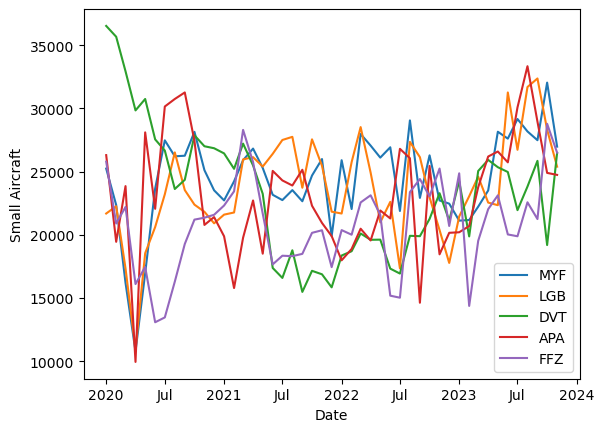

In [16]:
dfg = df.groupby('Facility')

fig, ax = plt.subplots()
for airport in total_flights.index[:5]:
    ax.plot(dfg.get_group(airport)['Date'],
            dfg.get_group(airport)['Small Plane Total'],
            label=airport)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.xlabel('Date')
plt.ylabel('Small Aircraft')
plt.legend()
plt.show()

Alright, this is a bit of a mess.
Other than the COVID dip in 2020, this visualization doesn't help very much.
Instead, a violin plot can help us understand how many small planes interact with the airport each month.

<Axes: xlabel='Facility', ylabel='Small Plane Total'>

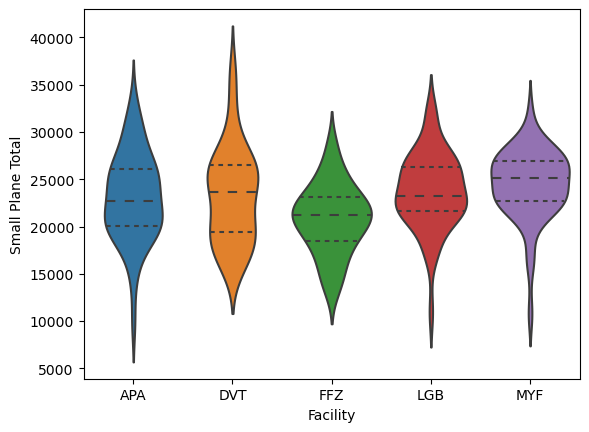

In [26]:
import seaborn as sns
sns.violinplot(data=df[df['Facility'].isin(total_flights.index[:5])],
            x='Facility', y='Small Plane Total', inner='quart', density_norm='count')


## Analysis